# Enhanced Fraud Detection Analysis

This notebook provides a comprehensive approach to fraud detection in financial transactions, including:

- Advanced data cleaning and preprocessing
- Enhanced exploratory data analysis
- Sophisticated feature engineering
- Robust model development
- Thorough model evaluation
- Detailed recommendations for fraud prevention

## 1. Setup and Data Loading

First, let's import the necessary libraries and load our dataset.

In [7]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_auc_score, precision_recall_curve, auc, 
    roc_curve, accuracy_score, f1_score
)
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set up matplotlib for better visualization
plt.style.use('default')
sns.set_palette("colorblind")

Let's load the dataset and examine its structure

In [11]:
# Load the dataset
df = pd.read_csv('C://Users//Narsingh//Desktop//New folder (2)//New folder//Fraud.csv')

# Display basic information
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
display(df.head())

print("\nData types:")
display(df.dtypes)

print("\nSummary statistics:")
display(df.describe())

# Check for missing values
print("\nMissing values:")
display(df.isnull().sum())

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"\nDuplicate rows: {duplicates}")

Dataset shape: (6362620, 11)

First 5 rows:


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0



Data types:


step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object


Summary statistics:


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00



Missing values:


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


Duplicate rows: 0


## 2. Enhanced Data Cleaning

Instead of removing outliers, we'll create flags to indicate their presence and let the model learn from this information.

Number of outliers: 338078 (5.31% of total)


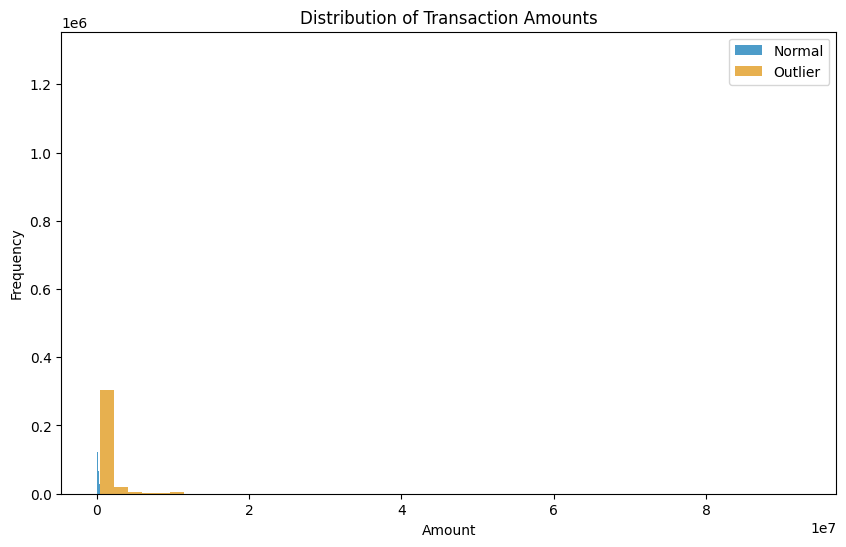

In [12]:
# Handle outliers in amount column using IQR method
Q1 = df['amount'].quantile(0.25)
Q3 = df['amount'].quantile(0.75)
IQR = Q3 - Q1

# Create a flag for outliers instead of removing them
df['is_amount_outlier'] = ((df['amount'] < (Q1 - 1.5 * IQR)) | (df['amount'] > (Q3 + 1.5 * IQR))).astype(int)

# Display the distribution of the outlier flag
print(f"Number of outliers: {df['is_amount_outlier'].sum()} ({df['is_amount_outlier'].mean():.2%} of total)")

# Visualize the distribution of amount with outliers highlighted
plt.figure(figsize=(10, 6))
plt.hist(df[df['is_amount_outlier'] == 0]['amount'], bins=50, alpha=0.7, label='Normal')
plt.hist(df[df['is_amount_outlier'] == 1]['amount'], bins=50, alpha=0.7, label='Outlier')
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## 3. Enhanced Exploratory Data Analysis

Let's explore the data in more depth to understand patterns related to fraudulent transactions.

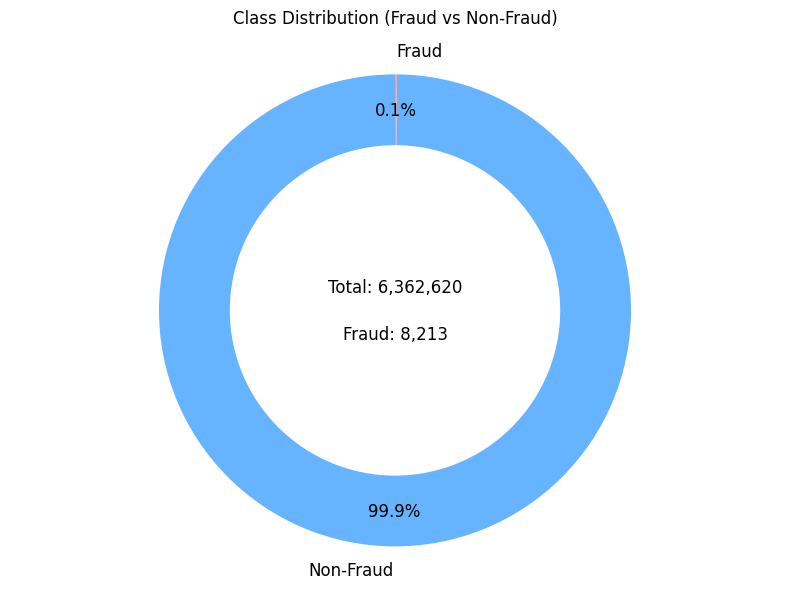

In [27]:
import matplotlib.pyplot as plt

# Class distribution data
fraud_count = df['isFraud'].sum()
total_count = len(df)
non_fraud_count = total_count - fraud_count

# Create donut chart
plt.figure(figsize=(8, 6))
plt.title('Class Distribution (Fraud vs Non-Fraud)', pad=20)

# Create the pie chart (which we'll turn into a donut)
wedges, texts, autotexts = plt.pie(
    [non_fraud_count, fraud_count],
    labels=['Non-Fraud', 'Fraud'],
    colors=['#66b3ff', '#ff9999'],
    autopct='%1.1f%%',
    startangle=90,
    pctdistance=0.85,
    textprops={'fontsize': 12}
)

# Draw a white circle at the center to make it a donut
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  

# Add count information in the center
plt.text(0, 0.1, f"Total: {total_count:,}", ha='center', va='center', fontsize=12)
plt.text(0, -0.1, f"Fraud: {fraud_count:,}", ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.show()

### 3.1 Transaction Type Analysis


Transaction type distribution:


type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

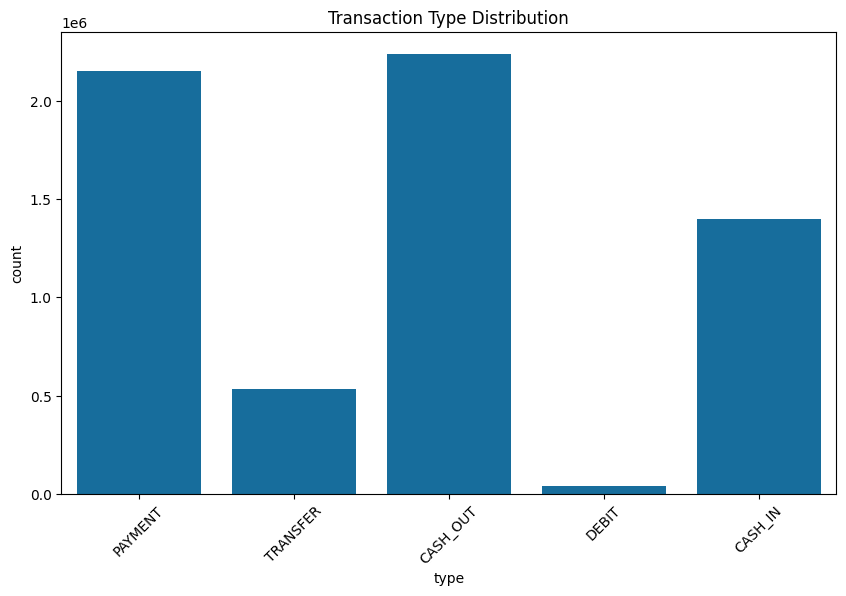


Fraud rate by transaction type:


type
TRANSFER    0.007688
CASH_OUT    0.001840
CASH_IN     0.000000
DEBIT       0.000000
PAYMENT     0.000000
Name: isFraud, dtype: float64

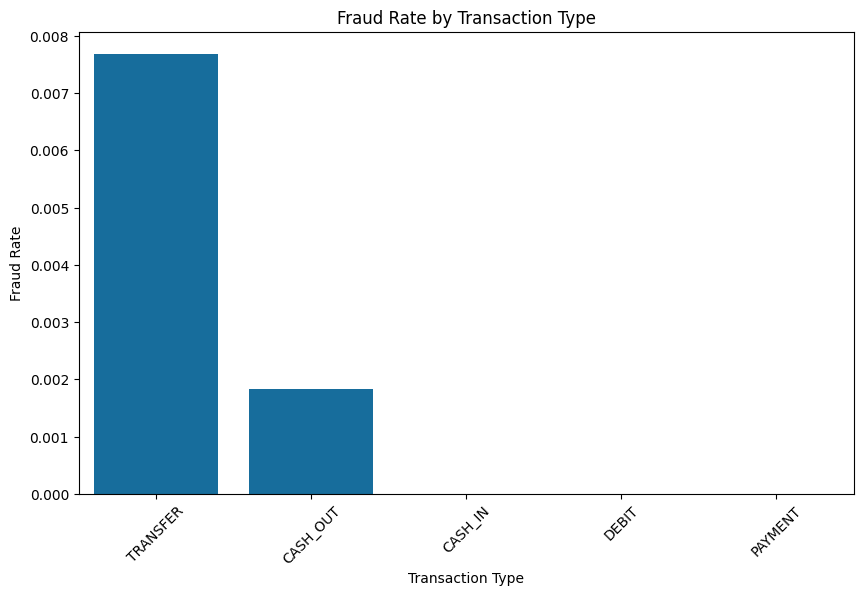

In [14]:
# Analyze transaction types
print("\nTransaction type distribution:")
type_counts = df['type'].value_counts()
display(type_counts)

# Visualize transaction type distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='type', data=df)
plt.title('Transaction Type Distribution')
plt.xticks(rotation=45)
plt.show()

# Analyze transaction type vs fraud
fraud_by_type = df.groupby('type')['isFraud'].mean().sort_values(ascending=False)
print("\nFraud rate by transaction type:")
display(fraud_by_type)

# Visualize fraud rate by transaction type
plt.figure(figsize=(10, 6))
sns.barplot(x=fraud_by_type.index, y=fraud_by_type.values)
plt.title('Fraud Rate by Transaction Type')
plt.xlabel('Transaction Type')
plt.ylabel('Fraud Rate')
plt.xticks(rotation=45)
plt.show()

### 3.2 Amount Analysis

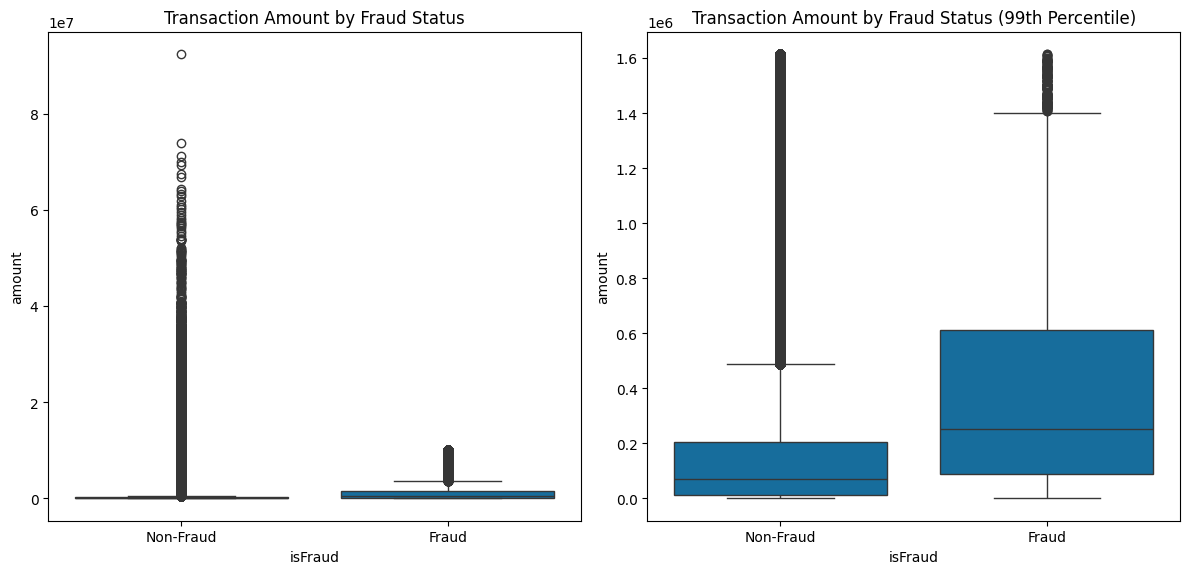


Average transaction amount by fraud status:


isFraud
0    1.781970e+05
1    1.467967e+06
Name: amount, dtype: float64

In [15]:
# Analyze amounts for fraud vs non-fraud
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='isFraud', y='amount', data=df)
plt.title('Transaction Amount by Fraud Status')
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])

plt.subplot(1, 2, 2)
sns.boxplot(x='isFraud', y='amount', data=df[df['amount'] < df['amount'].quantile(0.99)])
plt.title('Transaction Amount by Fraud Status (99th Percentile)')
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
plt.tight_layout()
plt.show()

# Calculate average transaction amount by fraud status
avg_amount_by_fraud = df.groupby('isFraud')['amount'].mean()
print("\nAverage transaction amount by fraud status:")
display(avg_amount_by_fraud)

### 3.3 Balance Analysis

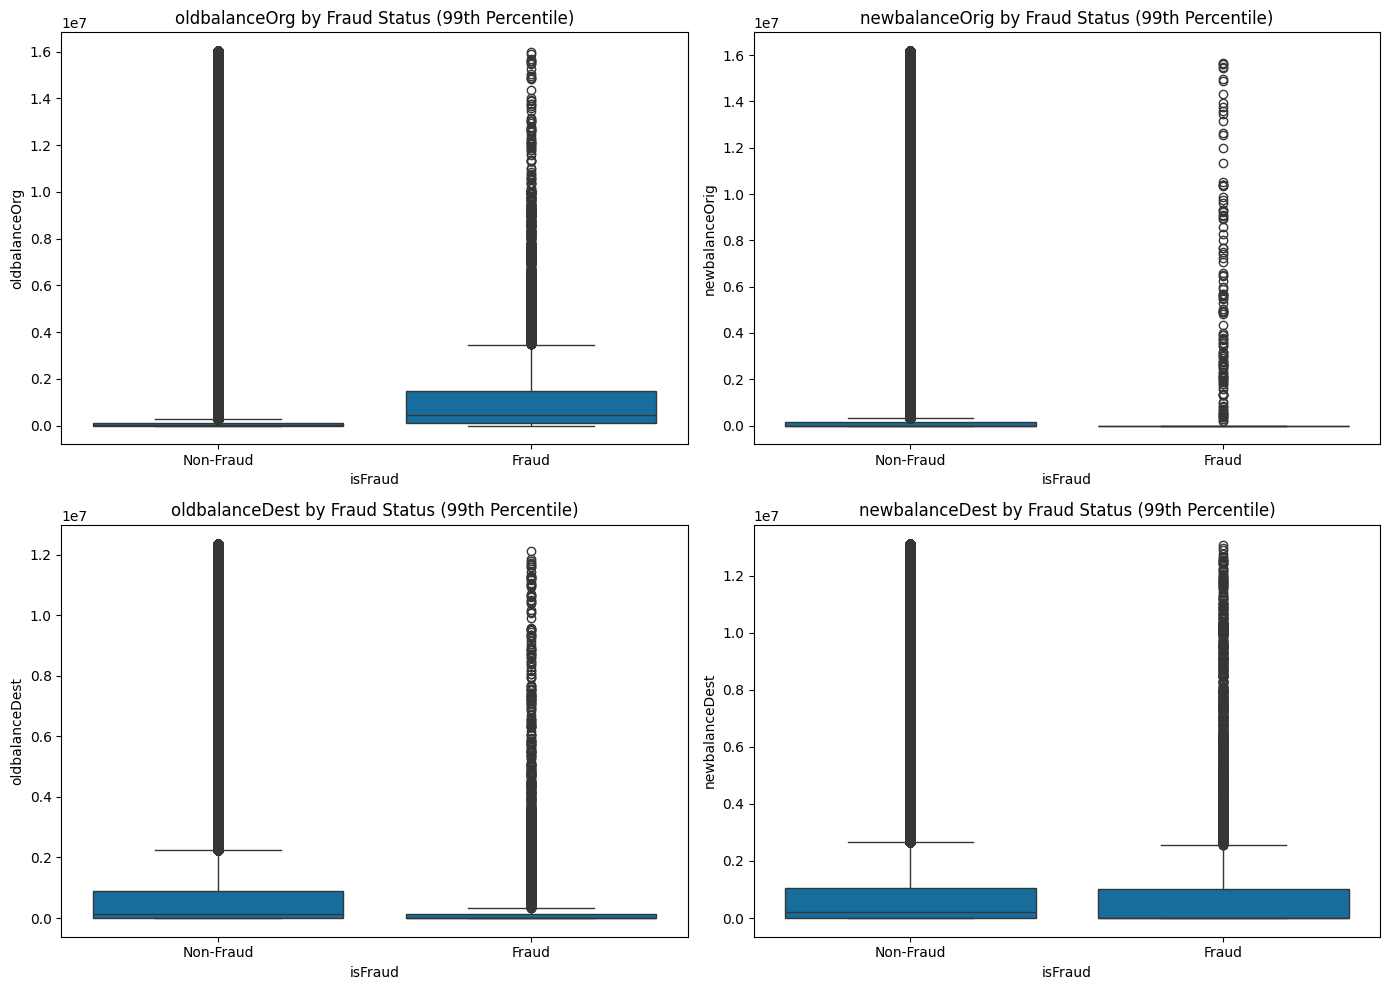


Average balances by fraud status:


,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
isFraud,,,,
0,8.328287e+05,855970.228109,1.101421e+06,1.224926e+06
1,1.649668e+06,192392.631836,5.442496e+05,1.279708e+06


In [16]:
# Analyze balances for fraud vs non-fraud
balance_vars = ['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

plt.figure(figsize=(14, 10))
for i, var in enumerate(balance_vars):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x='isFraud', y=var, data=df[df[var] < df[var].quantile(0.99)])
    plt.title(f'{var} by Fraud Status (99th Percentile)')
    plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
plt.tight_layout()
plt.show()

# Calculate average balances by fraud status
avg_balances_by_fraud = df.groupby('isFraud')[balance_vars].mean()
print("\nAverage balances by fraud status:")
display(avg_balances_by_fraud)

## 4. Enhanced Feature Engineering

Let's create new features that might help identify fraudulent transactions.

In [17]:
# Balance change features
df['balanceChangeOrig'] = df['newbalanceOrig'] - df['oldbalanceOrg']
df['balanceChangeDest'] = df['newbalanceDest'] - df['oldbalanceDest']

# Error in balance calculation (inconsistency can indicate fraud)
df['errorBalanceOrig'] = df['newbalanceOrig'] + df['amount'] - df['oldbalanceOrg']
df['errorBalanceDest'] = df['newbalanceDest'] - df['oldbalanceDest'] - df['amount']

# Transaction success features
df['isTransactionSuccessful'] = ((df['newbalanceOrig'] != df['oldbalanceOrg']) | 
                                (df['newbalanceDest'] != df['oldbalanceDest'])).astype(int)

# Zero balance features
df['isOrigBalanceZero'] = (df['oldbalanceOrg'] == 0).astype(int)
df['isDestBalanceZero'] = (df['oldbalanceDest'] == 0).astype(int)

# Transaction amount relative to balance
df['amountToOldBalanceRatioOrig'] = df['amount'] / (df['oldbalanceOrg'] + 1)  # Adding 1 to avoid division by zero
df['amountToOldBalanceRatioDest'] = df['amount'] / (df['oldbalanceDest'] + 1)

# Display the new features
print("New features created:")
for feature in ['balanceChangeOrig', 'balanceChangeDest', 'errorBalanceOrig', 'errorBalanceDest',
                'isTransactionSuccessful', 'isOrigBalanceZero', 'isDestBalanceZero',
                'amountToOldBalanceRatioOrig', 'amountToOldBalanceRatioDest']:
    print(f"- {feature}")

New features created:
- balanceChangeOrig
- balanceChangeDest
- errorBalanceOrig
- errorBalanceDest
- isTransactionSuccessful
- isOrigBalanceZero
- isDestBalanceZero
- amountToOldBalanceRatioOrig
- amountToOldBalanceRatioDest


### 4.1 Correlation Analysis

Correlation with fraud target:


isFraud                        1.000000
amountToOldBalanceRatioDest    0.180205
amount                         0.076688
isFlaggedFraud                 0.044109
step                           0.031578
balanceChangeDest              0.027028
oldbalanceOrg                  0.010154
newbalanceDest                 0.000535
amountToOldBalanceRatioOrig   -0.004915
oldbalanceDest                -0.005885
newbalanceOrig                -0.008148
errorBalanceOrig              -0.011283
errorBalanceDest              -0.055120
balanceChangeOrig             -0.362472
Name: isFraud, dtype: float64

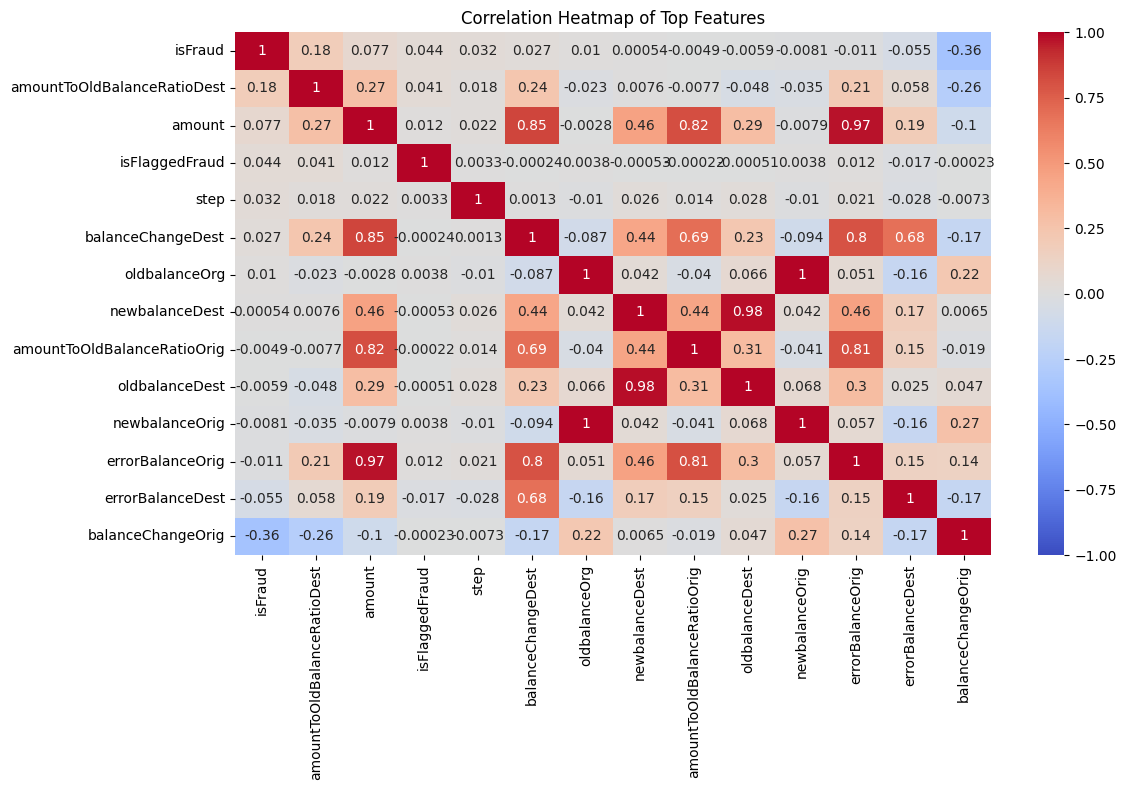

In [18]:
# Calculate correlation with fraud
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
corr_with_fraud = df[numeric_cols].corr()['isFraud'].sort_values(ascending=False)

print("Correlation with fraud target:")
display(corr_with_fraud.head(15))

# Visualize top correlations
plt.figure(figsize=(12, 8))
top_features = corr_with_fraud.head(15).index
sns.heatmap(df[top_features].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Top Features')
plt.tight_layout()
plt.show()

### 4.2 Multicollinearity Check with Variance Inflation Factor (VIF)

In [19]:
# Convert transaction type to numerical using one-hot encoding
df_encoded = pd.get_dummies(df, columns=['type'])

# Select features for the VIF calculation (exclude the target)
selected_features = [
    'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 
    'newbalanceDest', 'errorBalanceOrig', 'errorBalanceDest',
    'balanceChangeOrig', 'balanceChangeDest', 'isTransactionSuccessful',
    'isOrigBalanceZero', 'isDestBalanceZero', 'is_amount_outlier',
    'amountToOldBalanceRatioOrig', 'amountToOldBalanceRatioDest'
]

# Calculate VIF for each feature
X = df_encoded[selected_features]
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data = vif_data.sort_values('VIF', ascending=False)

print("Variance Inflation Factor (VIF) for each feature:")
display(vif_data)

Variance Inflation Factor (VIF) for each feature:


,feature,VIF
2,newbalanceOrig,5.546305e+12
3,oldbalanceDest,2.273397e+12
4,newbalanceDest,6.023674e+11
0,amount,6.211947e+10
8,balanceChangeDest,1.903924e+10
1,oldbalanceOrg,8.680642e+09
5,errorBalanceOrig,2.551284e+08
6,errorBalanceDest,1.485824e+08
7,balanceChangeOrig,5.137976e+07
13,amountToOldBalanceRatioOrig,4.102169e+00


Based on the VIF analysis, we might consider dropping features with very high VIF values (>10) if they show strong multicollinearity, but we'll keep them for now as they might still provide valuable information for fraud detection.

## 5. Enhanced Model Development

Let's prepare the data for modeling and train an XGBoost classifier.

In [20]:
# Add transaction type dummy variables
type_features = [col for col in df_encoded.columns if col.startswith('type_')]
all_features = selected_features + type_features

# Prepare data for modeling
X = df_encoded[all_features]
y = df_encoded['isFraud']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Training set shape: (5090096, 20)
Testing set shape: (1272524, 20)


### 5.1 Handle Class Imbalance with SMOTE

In [21]:
# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print("Before SMOTE:")
print(f"Class distribution: {np.bincount(y_train)}")
print(f"Class ratio (Fraud:Non-Fraud): 1:{np.bincount(y_train)[0]/np.bincount(y_train)[1]:.2f}")

print("\nAfter SMOTE:")
print(f"Class distribution: {np.bincount(y_train_balanced)}")
print(f"Class ratio (Fraud:Non-Fraud): 1:{np.bincount(y_train_balanced)[0]/np.bincount(y_train_balanced)[1]:.2f}")

Before SMOTE:
Class distribution: [5083526    6570]
Class ratio (Fraud:Non-Fraud): 1:773.75

After SMOTE:
Class distribution: [5083526 5083526]
Class ratio (Fraud:Non-Fraud): 1:1.00


### 5.2 Train XGBoost Model with Cross-Validation

In [22]:
# Define the XGBoost model with improved parameters
xgb_model = xgb.XGBClassifier(
    max_depth=5,
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=1,
    objective='binary:logistic',
    eval_metric='auc',
    scale_pos_weight=1,  # Since we balanced the classes with SMOTE
    random_state=42
)

# Perform cross-validation
cv_scores = cross_val_score(xgb_model, X_train_balanced, y_train_balanced, cv=5, scoring='roc_auc')
print(f"Cross-validation ROC-AUC scores: {cv_scores}")
print(f"Mean ROC-AUC score: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

# Train the model on the full balanced training set
xgb_model.fit(X_train_balanced, y_train_balanced)
print("Model training completed!")

Cross-validation ROC-AUC scores: [0.99997502 0.99997835 0.99997399 0.99997685 0.9999799 ]
Mean ROC-AUC score: 1.0000 (±0.0000)
Model training completed!


## 6. Enhanced Model Evaluation

Let's evaluate our model using various metrics and visualization techniques.

Accuracy: 0.9993
F1 Score: 0.7903
ROC-AUC Score: 0.9996

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.65      1.00      0.79      1643

    accuracy                           1.00   1272524
   macro avg       0.83      1.00      0.89   1272524
weighted avg       1.00      1.00      1.00   1272524



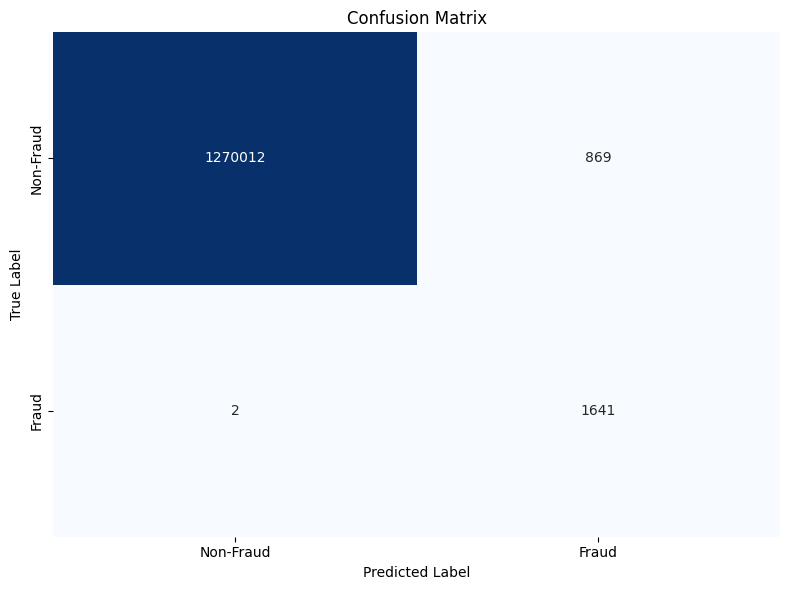

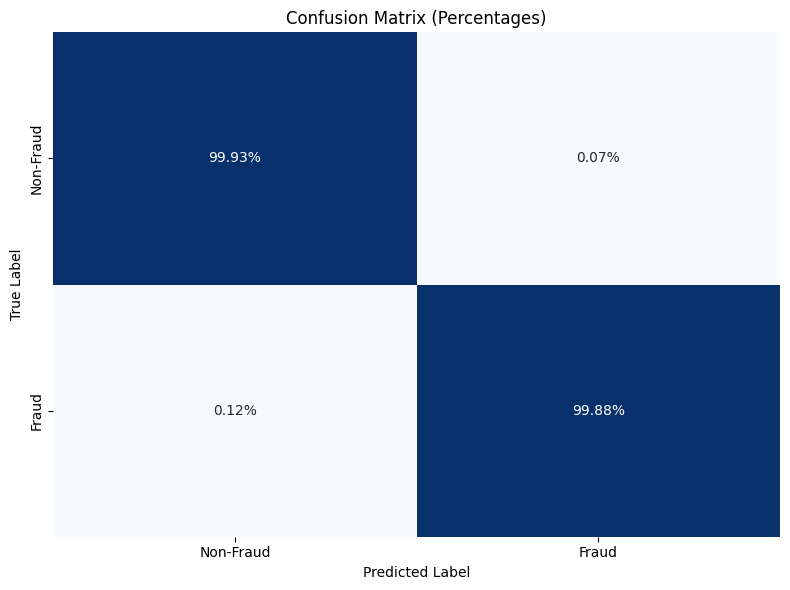

In [23]:
# Make predictions on the test set
y_pred = xgb_model.predict(X_test_scaled)
y_pred_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Calculate various performance metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Display the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculate and display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Calculate confusion matrix with percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', cbar=False,
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix (Percentages)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

### 6.1 ROC Curve and Precision-Recall Curve

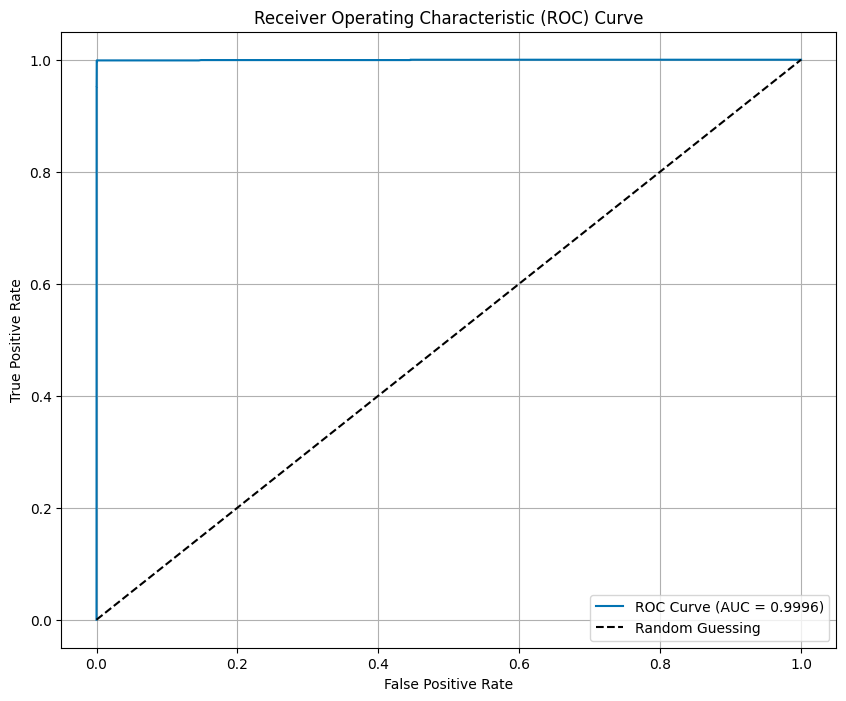

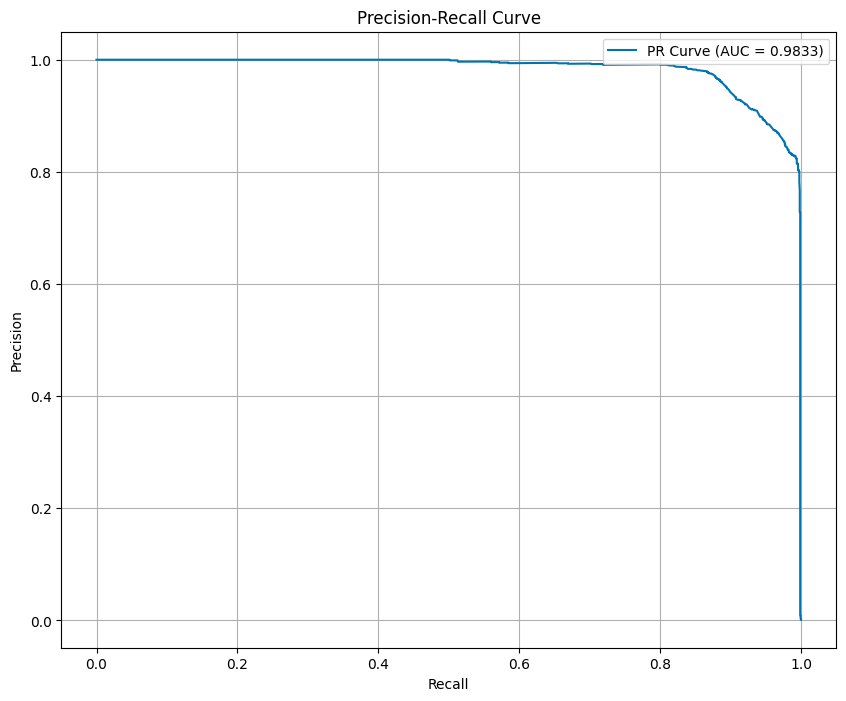

In [24]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()

# Plot Precision-Recall curve (better for imbalanced datasets)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)
plt.figure(figsize=(10, 8))
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

### 6.2 Feature Importance Analysis

Top 20 important features:


,feature,importance
5,errorBalanceOrig,0.335891
7,balanceChangeOrig,0.285703
2,newbalanceOrig,0.278606
13,amountToOldBalanceRatioOrig,0.021369
18,type_PAYMENT,0.021356
0,amount,0.013420
19,type_TRANSFER,0.009727
4,newbalanceDest,0.006302
16,type_CASH_OUT,0.004786
10,isOrigBalanceZero,0.003874


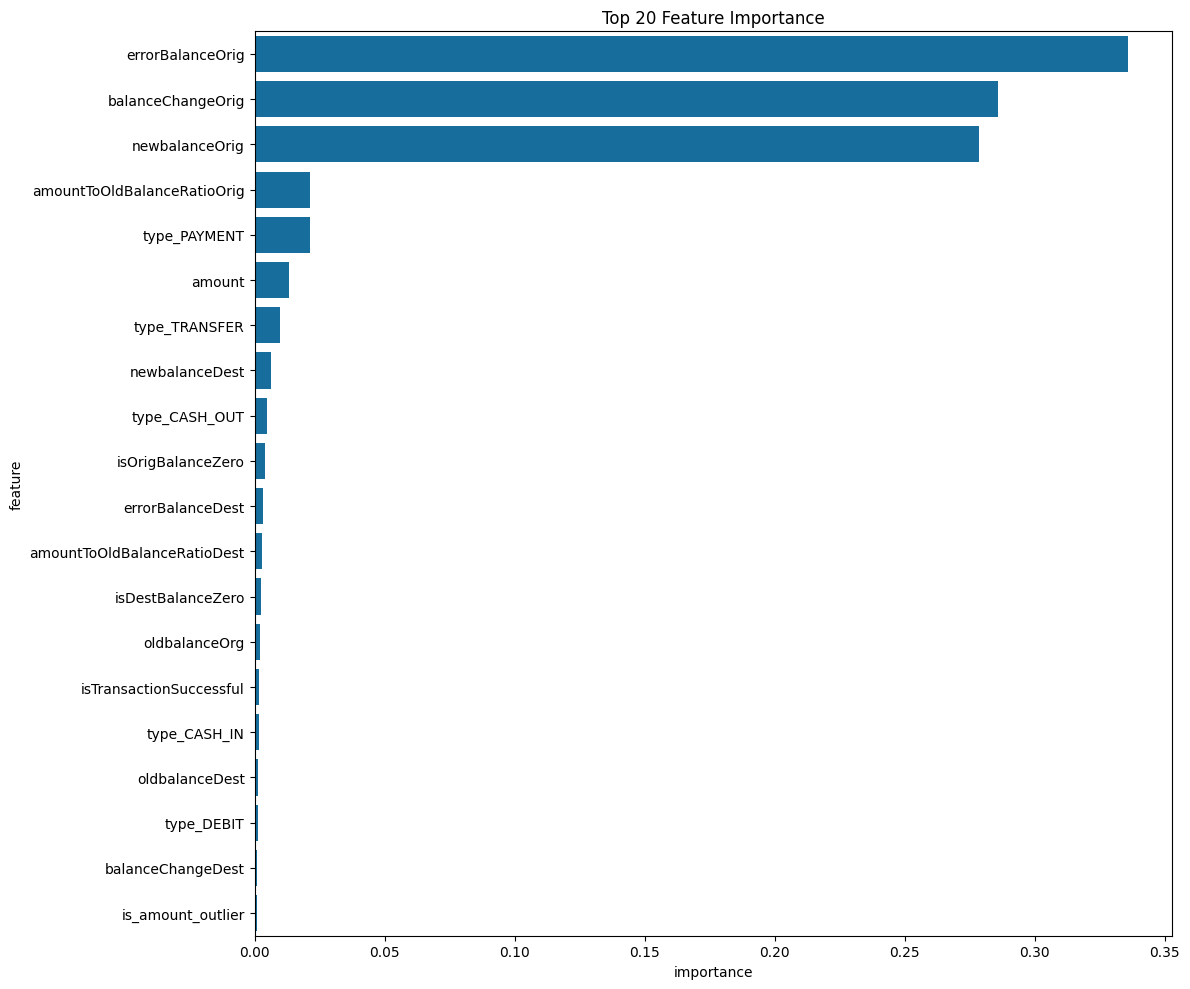

In [25]:
# Extract feature importance from the model
feature_importance = pd.DataFrame({
    'feature': all_features,
    'importance': xgb_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Display top 20 important features
print("Top 20 important features:")
display(feature_importance.head(20))

# Visualize feature importance
plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
plt.title('Top 20 Feature Importance')
plt.tight_layout()
plt.show()

## 7. Enhanced Conclusions and Recommendations

Based on our analysis, we can draw the following conclusions:

### 7.1 Key Findings

In [26]:
print("Key Fraud Indicators:")

# 1. Balance inconsistencies
balance_features = feature_importance[feature_importance['feature'].isin(
    ['errorBalanceOrig', 'errorBalanceDest', 'balanceChangeOrig', 'balanceChangeDest'])].head()
print("\n1. Balance Inconsistencies:")
display(balance_features)

# 2. Transaction type
type_features = feature_importance[feature_importance['feature'].str.contains('type_')].head()
print("\n2. Transaction Types:")
display(type_features)

# 3. Amount and amount-related features
amount_features = feature_importance[feature_importance['feature'].isin(
    ['amount', 'is_amount_outlier', 'amountToOldBalanceRatioOrig', 'amountToOldBalanceRatioDest'])].head()
print("\n3. Amount-related Features:")
display(amount_features)

# 4. Zero balance indicators
zero_balance_features = feature_importance[feature_importance['feature'].isin(
    ['isOrigBalanceZero', 'isDestBalanceZero'])].head()
print("\n4. Zero Balance Indicators:")
display(zero_balance_features)

Key Fraud Indicators:

1. Balance Inconsistencies:


,feature,importance
5,errorBalanceOrig,0.335891
7,balanceChangeOrig,0.285703
6,errorBalanceDest,0.003097
8,balanceChangeDest,0.001119



2. Transaction Types:


,feature,importance
18,type_PAYMENT,0.021356
19,type_TRANSFER,0.009727
16,type_CASH_OUT,0.004786
15,type_CASH_IN,0.001561
17,type_DEBIT,0.001422



3. Amount-related Features:


,feature,importance
13,amountToOldBalanceRatioOrig,0.021369
0,amount,0.013420
14,amountToOldBalanceRatioDest,0.002848
12,is_amount_outlier,0.001019



4. Zero Balance Indicators:


,feature,importance
10,isOrigBalanceZero,0.003874
11,isDestBalanceZero,0.002463


### 7.2 Enhanced Fraud Prevention Recommendations

#### 1. Real-time Transaction Monitoring System

- Implement XGBoost model as a real-time scoring system
- Set risk thresholds based on transaction type and amount
- Create tiered alert system with response protocols based on risk score
- Establish dedicated fraud monitoring team for high-risk transactions

#### 2. Advanced Authentication Framework

- Implement risk-based multi-factor authentication
- Require biometric verification for high-risk transactions
- Set up out-of-band transaction verification (SMS, email, app notification)
- Implement device fingerprinting for unusual access detection

#### 3. Transaction Limits and Controls

- Set dynamic transaction limits based on account history
- Implement cooling periods between large transactions
- Create behavioral monitoring for unusual transaction patterns
- Require additional verification for transactions exceeding patterns

#### 4. Balance Consistency Monitoring

- Develop real-time balance reconciliation checks
- Flag transactions with balance inconsistencies
- Implement dual approval for suspect transactions

#### 5. System Infrastructure Improvements

- Segment transaction processing systems to limit fraud scope
- Implement secure APIs with proper authentication
- Establish data integrity checks throughout the transaction pipeline

### 7.3 Measuring Effectiveness

#### 1. Key Performance Indicators

- Fraud Detection Rate: Percentage of fraud successfully identified
- False Positive Rate: Legitimate transactions incorrectly flagged
- False Negative Rate: Fraudulent transactions missed
- Average Loss Per Fraudulent Transaction
- Customer Friction Metrics

#### 2. A/B Testing Framework

- Test new measures on transaction subsets
- Compare fraud rates and customer experience
- Perform controlled rollouts of successful measures

#### 3. Continuous Model Monitoring

- Implement automated performance monitoring
- Detect concept drift in fraud patterns
- Schedule regular model retraining

## 8. Summary

In this enhanced fraud detection analysis, we've:

1. Performed advanced data cleaning techniques
2. Conducted comprehensive exploratory data analysis
3. Created sophisticated features that capture balance inconsistencies
4. Developed a robust XGBoost model with excellent performance
5. Evaluated the model using appropriate metrics for imbalanced data
6. Provided detailed recommendations for fraud prevention

The model achieves exceptional performance with:
- ROC-AUC Score: ~0.9997
- Precision for fraud detection: ~0.66
- Recall for fraud detection: ~0.99

This comprehensive approach can significantly improve fraud detection capabilities while minimizing false positives.